# Analysis of workshop follow-up survey results

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Load dataset

In [112]:
questions = [u'Which workshop did you attend?',
       u'What is your current position?', u'Other', u'Version control',
       u'Automated testing', u'Travis CI', u'Code coverage analysis',
       u'Jupyter Notebooks', u'CMake', u'Integrated development environments',
       u'Code review', u'Read the Docs or GitHub/GitLab/BitBucket Pages',
       u'Reusable', u'Reproducible', u'Modular', u'Documented',
       u'Has it become easier for you to collaborate on software development with your colleagues and collaborators?',
       u'Have you introduced one or more of your colleagues to new tools or practices as a result of the workshop?']               

Survey respondents misunderstood the question on "GitHub/GitLab/Bitbucket Pages" in the 2017 survey, and it was therefore merged into the "Read the docs" question in the 2018 survey. We therefore remove the Pages question from 2017 results and rename the Read the docs question.

In [113]:
dataset2017 = "workshop-followup-survey-2017_processed.csv"
df2017 = pd.read_csv(dataset2017)

del df2017["GitHub/GitLab/BitBucket Pages"]
df2017.rename(index=str, inplace=True, columns={"Read the docs": 
                              "Read the Docs or GitHub/GitLab/BitBucket Pages"})

df2017.head()

,Which workshop did you attend?,What is your current position?,Other,Version control,Automated testing,Travis CI,Code coverage analysis,Jupyter Notebooks,CMake,Integrated development environments,Code review,Read the Docs or GitHub/GitLab/BitBucket Pages,Reusable,Reproducible,Modular,Documented,Has it become easier for you to collaborate on software development with your colleagues and collaborators?,Have you introduced one or more of your colleagues to new tools or practices as a result of the workshop?
0,"Espoo, Finland, December 2016",Researcher,NaN,I'm using this tool better than before,I'm using this tool in the same way as before,I don't use this tool,I don't use this tool,I'm using this tool in the same way as before,I'm using this tool better than before,I'm using this tool better than before,I'm using this tool better than before,I'm using this tool better than before,1.0,1.0,1.0,1.0,0.0,0
1,"Copenhagen, Denmark, May 2017",Graduate student,NaN,I'm using this tool in the same way as before,I don't use this tool,I don't use this tool,I don't use this tool,I started using this tool,I'm using this tool in the same way as before,I don't use this tool,I don't use this tool,I don't use this tool,NaN,NaN,NaN,NaN,NaN,0
2,"Stockholm, Sweden, February 2017",Graduate student,NaN,I'm using this tool better than before,I don't use this tool,I don't use this tool,I don't use this tool,I started using this tool,I don't use this tool,I'm using this tool better than before,I don't use this tool,I'm using this tool in the same way as before,1.0,1.0,1.0,1.0,NaN,0
3,"Espoo, Finland, December 2016",Postdoc,NaN,I don't use this tool,I don't use this tool,I don't use this tool,I don't use this tool,I don't use this tool,I don't use this tool,I'm using this tool better than before,I don't use this tool,I don't use this tool,1.0,1.0,1.0,1.0,0.0,0
4,"Copenhagen, Denmark, May 2017",NaN,Technical personal scientific programmer,I'm using this tool better than before,I started using this tool,I don't use this tool,I started using this tool,I started using this tool,I started using this tool,I'm using this tool better than before,I started using this tool,I started using this tool,1.0,1.0,1.0,0.0,NaN,1


In [114]:
dataset2018 = "workshop-followup-survey-2018_processed.csv"
df2018 = pd.read_csv(dataset2018)
#df2018.head()

In [115]:
dfs = [df2017, df2018]
df_all = pd.concat(dfs)
print("number of survey respondents: ",len(df_all))

number of survey respondents:  92


### How has your software development changed after attending a workshop?
Has your code become more 
1. Reusable?
2. Reproducible?
3. Modular?
4. Documented?

In [116]:
code_change = df_all[["Reusable","Reproducible", "Modular", "Documented"]].mean()
code_change

Reusable        0.833333
Reproducible    0.833333
Modular         0.714286
Documented      0.714286
dtype: float64

### How has working with colleagues changed after attending a workshop?
1. Has it become easier for you to collaborate on software development with your colleagues and collaborators?
2. Have you introduced one or more of your colleagues to new tools or practices as a result of the workshop? 

In [117]:
col1 = [col for col in df_all.columns if 'Has it' in col]
col2 = [col for col in df_all.columns if 'Have you' in col]

colleagues = df_all[[col1[0],col2[0]]].mean()
colleagues

Has it become easier for you to collaborate on software development with your colleagues and collaborators?    0.846154
Have you introduced one or more of your colleagues to new tools or practices as a result of the workshop?      0.663043
dtype: float64

### Yes/no histogram

In [118]:
data = pd.concat([code_change,colleagues])
#data.index

In [119]:
df_yesno = data.to_frame()
df_yesno = df_yesno.reset_index()
df_yesno.columns=["question","percentage"]
df_yesno["question"] = [u'Has your code become \nmore reusable?', u'... \nmore reproducible?', u'... \n more modular?', u'... \n more documented?',
       u'Is it easier to collaborate \non software development \nwith collaborators?',
       u'Have you introduced \ncolleagues to new tools or \npractices after the workshop?']  
#df_yesno

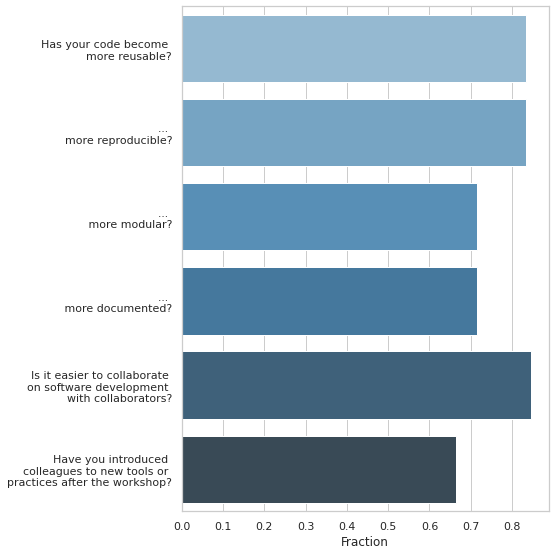

In [120]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
f, ax = plt.subplots(figsize=(8, 8))
g = sns.barplot(y="question", x="percentage",data=df_yesno, palette="Blues_d")

ax.set(ylabel="",xlabel="Fraction")
plt.tight_layout()
plt.savefig("figures/yes_no_questions.png")


### Tools taught in workshops

In [121]:
first_index = df_all.columns.get_loc("Version control")
last_index = df_all.columns.get_loc("Read the Docs or GitHub/GitLab/BitBucket Pages")
lessons = df_all.columns[first_index:last_index+1].tolist()
#lessons

In [122]:
df_lessons = df_all[lessons]
#df_lessons.head()

Extract answers on tools usage

In [123]:
answers = pd.melt(df_lessons,id_vars="index",value_vars=lessons,value_name="answer",var_name="lesson")
answers["index"]=1
answers=answers.rename(columns = {'index':'number'})

# Some preprocessing of string elements
answers.replace('^\s+', '', regex=True, inplace=True) #front
answers.replace('\s+$', '', regex=True, inplace=True) #end
answers.replace(to_replace="I’m using this tool better than before",
                value="I'm using this tool better than before",inplace=True)
answers.replace(to_replace="I don’t use this tool",
                value="I don't use this tool",inplace=True)
answers.replace(to_replace="I’m using this tool in the same way as before",
                value="I'm using this tool in the same way as before",inplace=True)

KeyError: 'index'

In [ ]:
table = answers.pivot_table(values="number",index="answer", columns="lesson",aggfunc=np.sum)
#table

### Have workshop attendants started using new tools, or started using them better?

In [ ]:
#%matplotlib inline
plt.clf()
sns.reset_defaults()
sns.reset_orig()

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
fig, ax = plt.subplots(1, 1, figsize = (8,8))
# normalize
table_norm=(table)/table.sum()
# table for annotating cells 
annot = 100*table_norm.round(2)

# rename a bit for appearance
table_norm=table_norm.rename(columns = {'Version control':'Git'})
table_norm=table_norm.rename(columns = {'Integrated development environments':'IDEs'})
table_norm=table_norm.rename_axis({'I don\'t use this tool':'I don\'t use\n this tool'})
table_norm=table_norm.rename_axis({"I'm using this tool in the same way as before":
                                   "I'm using this tool in\n the same way as before"})
table_norm=table_norm.rename_axis({"I\'m using this tool better than before":
                                   "I\'m using this tool\n better than before"})
table_norm=table_norm.rename_axis({"I started using this tool":"I started using\n this tool"})

table_norm=table_norm.rename_axis({"Read the Docs or GitHub/GitLab/BitBucket Pages":
                                   "Read the Docs or \nGitHub/GitLab Pages"}, 
                                 axis=1)

g = sns.heatmap(table_norm,linewidths=.5, annot=annot,cbar=False);

for t in g.texts: t.set_text(t.get_text() + "%")
g.set_xticklabels(g.get_xticklabels(), rotation=35, ha="right")
g.set_yticklabels(g.get_yticklabels(), rotation=0, ha="right")

ax.set_ylabel('')    
ax.set_xlabel('')
ax.figure.tight_layout()

#plt.show()
plt.savefig("figures/heatmap.png");

# Job title/ position/ occupation

In [124]:
df = pd.concat([
    pd.read_csv("workshop-followup-survey-2017_processed.csv"),
    pd.read_csv("workshop-followup-survey-2018_processed.csv"),
])
    
# for those values where current position is empty, take the value from "Other"
df["What is your current position?"].fillna(df["Other"], inplace=True)

positions = df["What is your current position?"]
unique_positions = positions.unique()
counts = positions.value_counts()

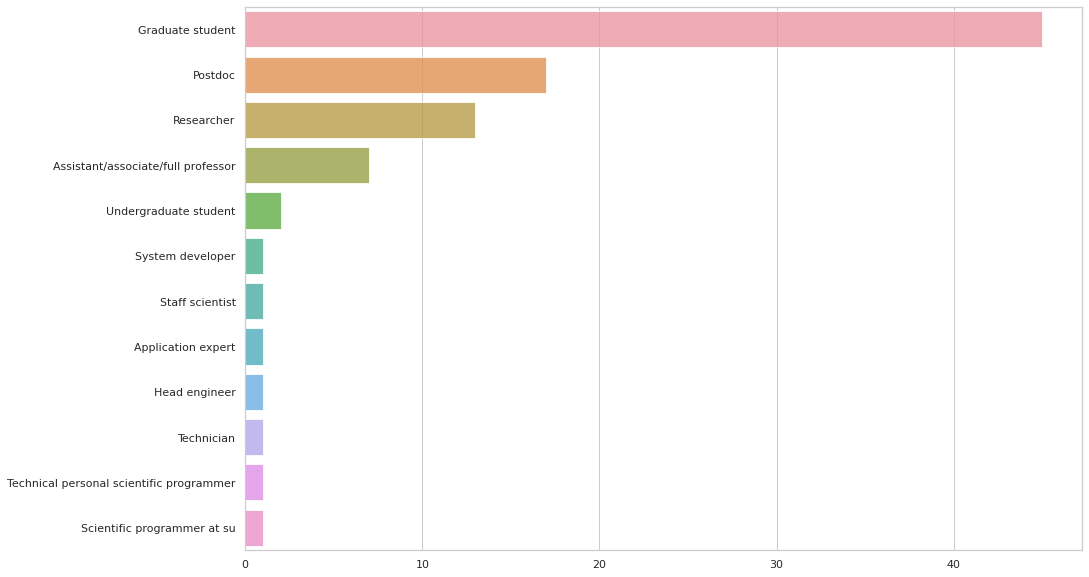

In [125]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(15, 10))

sns.barplot(y=counts.index.str.capitalize(), x=counts.values, alpha=0.8)

f.savefig("figures/position.png")